In [1]:
# importing packages and data

import numpy as np
from numpy.fft import fft
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, brute, fmin
from scipy.integrate import quad
from scipy.interpolate import splev, splrep

np.random.seed(42)
pd.options.mode.chained_assignment = None  # default='warn'

# data from xlsx file
data_given = {
    'Days to Maturity': [15, 15, 15, 15, 15, 60, 60, 60, 60, 60, 120, 120, 120, 120, 120, 
                         15, 15, 15, 15, 15, 60, 60, 60, 60, 60, 120, 120, 120, 120, 120],
    'Strike': [227.5, 230, 232.5, 235, 237.5, 227.5, 230, 232.5, 235, 237.5, 
               227.5, 230, 232.5, 235, 237.5, 227.5, 230, 232.5, 235, 237.5, 
               227.5, 230, 232.5, 235, 237.5, 227.5, 230, 232.5, 235, 237.5],
    'Price': [10.52, 10.05, 7.75, 6.01, 4.75, 16.78, 17.65, 16.86, 16.05, 15.1, 27.92, 
              24.12, 22.97, 21.75, 18.06, 4.32, 5.2, 6.45, 7.56, 8.78, 11.03, 12.15, 
              13.37, 14.75, 15.62, 14.53, 16.25, 17.22, 18.74, 19.73],
    'Type': ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 
             'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
    }
df = pd.DataFrame(data=data_given)

# grouping calls and puts
df_calls = df[df["Type"]=="C"]
df_calls= df_calls.rename(columns={"Price": "Call"})
df_calls = df_calls.drop(["Type"], axis=1)
df_puts = df[df["Type"]=="P"]
df_puts= df_puts.rename(columns={"Price": "Put"})
df_puts = df_puts.drop(["Type"], axis=1)
df = pd.merge(df_puts,df_calls, on=["Days to Maturity", "Strike"], how='outer')

# Adding Time-to-Maturity and constant short-rates
df['T'] = df['Days to Maturity'] / 365
df['r'] = 0.015
# df.head()

## Step 1

### The Lewis approach to calibrate the Heston (1993) model

In [2]:
# Adapted from Stochastic Modeling Module 1 Lesson 4

# for European call options
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    '''Heston 1993 characteristic function'''
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    return np.exp(H1 + H2 * v0)

def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    '''Heston 1993 integral function'''
    cf_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
    )
    int_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * cf_value).real
    )
    return int_value

def H93_call_Lewis(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    '''Valuation of European call option in Heston 1993 model via Lewis approach'''
    int_value = quad(
        lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

def put_from_call(C, S0, K, r, T):
    return C - S0 + K * np.exp(-r * T)

# using put-call parity to price put options
def H93_put_Lewis(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    call_value = H93_call_Lewis(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    return put_from_call(call_value, S0, K, r, T)


def H93_error_function(p0, call_func, put_func):
    '''MSE as error function for calibration via Lewis approach for Heston (1993)'''
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        call_value = call_func(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        put_value = put_func(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        se.append((put_value-option["Put"])**2 + (call_value-option["Call"])**2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    # if i % 25 == 0:
    #     print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def H93_calibration_full(call_func, put_func):
    '''Calibrates Heston (1993) stochastic volatility model to market quotes'''
    
    p0 = brute(
        lambda x: H93_error_function(x,call_func,put_func),
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None, 
    )

    opt = fmin(
        lambda x: H93_error_function(x,call_func,put_func), 
            p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900, disp=False
    )
    
    return opt

# Option parameters
S0 = 232.90
K = 235
r = 0.015
T = 15.0/365.0

# Option Selection
tol = 0.02  # Tolerance level to select ATM options (percent around ITM/OTM options)
options = df[(np.abs(df["Strike"]/S0-1)<tol) & (df["Days to Maturity"]==15)]
print(f"To calibrate our Heston model, we choose only those options with 15 days to maturity and strikes that are 2% from S0 ({S0}).")
options

To calibrate our Heston model, we choose only those options with 15 days to maturity and strikes that are 2% from S0 (232.9).


,Days to Maturity,Strike,Put,Call,T,r
1,15,230.0,5.20,10.05,0.041096,0.015
2,15,232.5,6.45,7.75,0.041096,0.015
3,15,235.0,7.56,6.01,0.041096,0.015
4,15,237.5,8.78,4.75,0.041096,0.015


In [3]:
i = 0
min_MSE = 500
calibrated_heston_Lewis = dict(zip(["kappa_v", "theta_v", "sigma_v", "rho", "v0"], 
                        H93_calibration_full(H93_call_Lewis, H93_put_Lewis)))

print("Calibrated Heston 1993 model parameters under Lewis: ")
for k in calibrated_heston_Lewis:
    print(f"{k}:\t{round(calibrated_heston_Lewis[k],7)}")

Calibrated Heston 1993 model parameters under Lewis: 
kappa_v:	12.1999777
theta_v:	0.0103035
sigma_v:	0.0560699
rho:	-0.0128791
v0:	0.1711087


Using the Heston 1993 model with calibrated parameters to price options


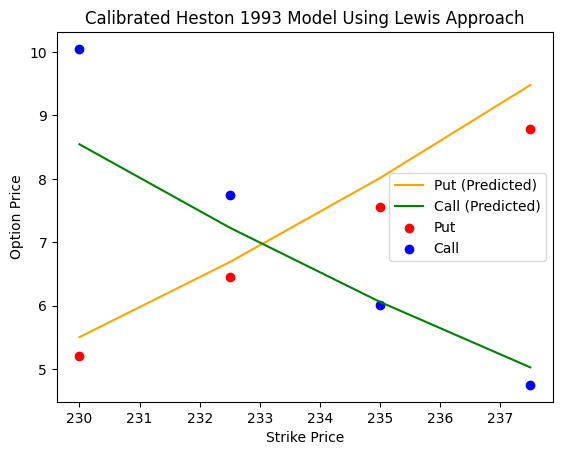

In [4]:
print("Using the Heston 1993 model with calibrated parameters to price options")

options['Call (Predicted)'] = df.apply(lambda x: H93_call_Lewis(
            S0,
            x["Strike"],
            x["T"],
            x["r"],
            calibrated_heston_Lewis["kappa_v"],
            calibrated_heston_Lewis["theta_v"],
            calibrated_heston_Lewis["sigma_v"],
            calibrated_heston_Lewis["rho"],
            calibrated_heston_Lewis["v0"],
        ), axis=1)
options['Put (Predicted)'] = df.apply(lambda x: H93_put_Lewis(
            S0,
            x["Strike"],
            x["T"],
            x["r"],
            calibrated_heston_Lewis["kappa_v"],
            calibrated_heston_Lewis["theta_v"],
            calibrated_heston_Lewis["sigma_v"],
            calibrated_heston_Lewis["rho"],
            calibrated_heston_Lewis["v0"],
        ), axis=1)

plt.scatter(options['Strike'], options['Put'], color='red', label='Put')
plt.plot(options['Strike'], options['Put (Predicted)'], color='orange', label='Put (Predicted)')
plt.scatter(options['Strike'], options['Call'], color='blue', label='Call')
plt.plot(options['Strike'], options['Call (Predicted)'], color='green', label='Call (Predicted)')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Calibrated Heston 1993 Model Using Lewis Approach')
plt.legend()
plt.show()

### The Carr-Madan approach to calibrate the Heston (1993) model

In [5]:
def H93_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    '''European Call option price in Heston 1993 under FFT'''

    k = np.log(K / S0)
    x0 = np.log(S0 / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            H93_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - H93_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - H93_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

# using put-call parity to price put options
def H93_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    call_value = H93_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    return put_from_call(call_value, S0, K, r, T)

In [6]:
i = 0
min_MSE = 500
calibrated_heston_FFT = dict(zip(["kappa_v", "theta_v", "sigma_v", "rho", "v0"], 
                        H93_calibration_full(H93_call_FFT, H93_put_FFT)))

print("Calibrated Heston 1993 model parameters under Carr-Madan: ")
for k in calibrated_heston_FFT:
    print(f"{k}:\t{round(calibrated_heston_FFT[k],7)}")

Calibrated Heston 1993 model parameters under Carr-Madan: 
kappa_v:	7.9619829
theta_v:	0.0176
sigma_v:	0.0615781
rho:	-0.0091954
v0:	0.1573166


Using the Heston 1993 model with calibrated parameters to price options


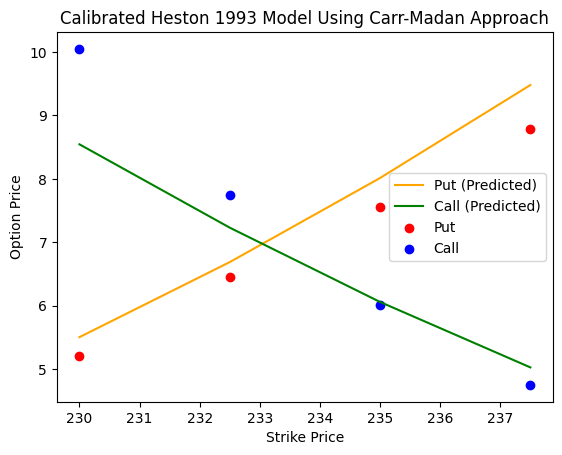

In [7]:
print("Using the Heston 1993 model with calibrated parameters to price options")

# overwrites dataframe from previous section
options['Call (Predicted)'] = df.apply(lambda x: H93_call_FFT(
            S0,
            x["Strike"],
            x["T"],
            x["r"],
            calibrated_heston_FFT["kappa_v"],
            calibrated_heston_FFT["theta_v"],
            calibrated_heston_FFT["sigma_v"],
            calibrated_heston_FFT["rho"],
            calibrated_heston_FFT["v0"],
        ), axis=1)
options['Put (Predicted)'] = df.apply(lambda x: H93_put_FFT(
            S0,
            x["Strike"],
            x["T"],
            x["r"],
            calibrated_heston_FFT["kappa_v"],
            calibrated_heston_FFT["theta_v"],
            calibrated_heston_FFT["sigma_v"],
            calibrated_heston_FFT["rho"],
            calibrated_heston_FFT["v0"],
        ), axis=1)

plt.scatter(options['Strike'], options['Put'], color='red', label='Put')
plt.plot(options['Strike'], options['Put (Predicted)'], color='orange', label='Put (Predicted)')
plt.scatter(options['Strike'], options['Call'], color='blue', label='Call')
plt.plot(options['Strike'], options['Call (Predicted)'], color='green', label='Call (Predicted)')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Calibrated Heston 1993 Model Using Carr-Madan Approach')
plt.legend()
plt.show()

$\kappa_v$ parameter seems off compared to calibrating under Lewis approach. However, the predictions are mostly consistent.

## Pricing asian option with calibrated Heston model

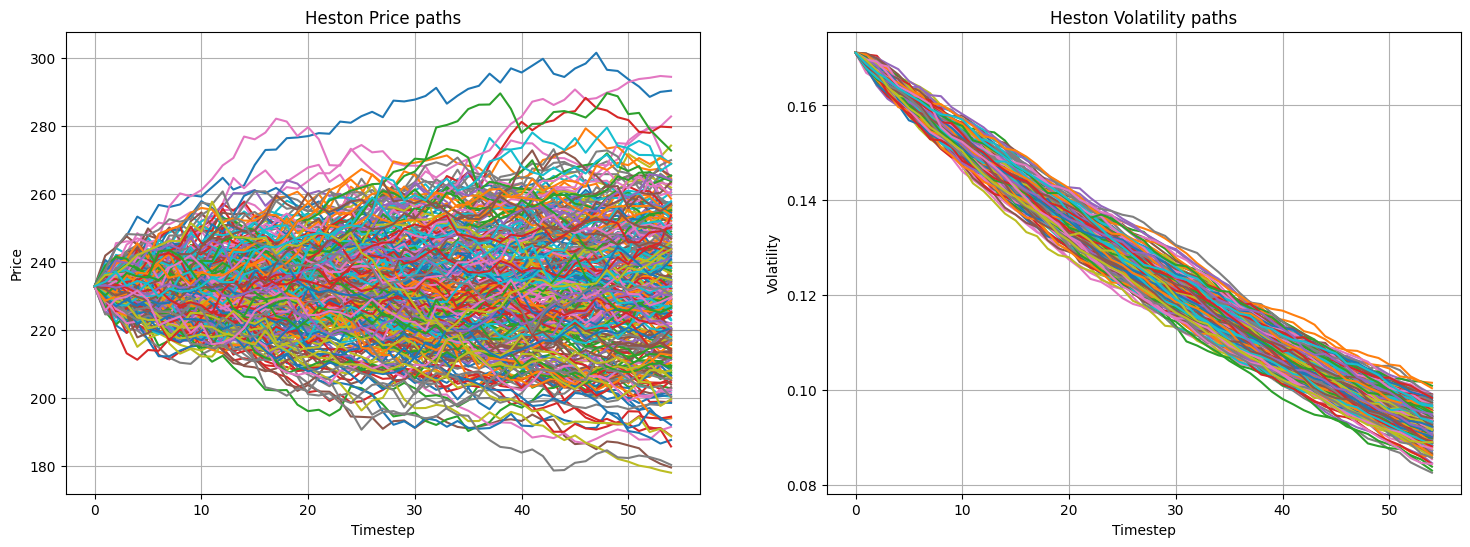

In [8]:
T = 20.0/365

# Adapted from Derivative Pricing Module 7 Lesson 2

# stochastic volatility
def SDE_vol(v0, kappa, theta, sigma, T, M, Ite, rand, row, cho_matrix):
    dt = T / M  # T = maturity, M = number of time steps
    v = np.zeros((M + 1, Ite), dtype=np.float)
    v[0] = v0
    sdt = np.sqrt(dt)  # Sqrt of dt
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        v[t] = np.maximum(
            0,
            v[t - 1]
            + kappa * (theta - v[t - 1]) * dt
            + np.sqrt(v[t - 1]) * sigma * ran[row] * sdt,
        )
    return v

# underlying stock prices
def Heston_paths(S0, r, v, row, cho_matrix):
    S = np.zeros((M + 1, Ite), dtype=float)
    S[0] = S0
    sdt = np.sqrt(dt)
    for t in range(1, M + 1, 1):
        ran = np.dot(cho_matrix, rand[:, t])
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[row] * sdt)

    return S

M0 = 1000  # Number of time steps in a year
M = int(M0 * T)  # Total time steps
Ite = 10000  # Number of simulations
dt = T / M  # Length of time step

# Using the parameters obtained under the Lewis approach
v0 = calibrated_heston_Lewis["v0"]
kappa_v = calibrated_heston_Lewis["kappa_v"]
sigma_v = calibrated_heston_Lewis["sigma_v"]
theta_v = calibrated_heston_Lewis["theta_v"]
rho = calibrated_heston_Lewis["rho"]

# Generating random numbers from standard normal
rand = np.random.standard_normal((2, M + 1, Ite))

# Covariance Matrix
covariance_matrix = np.zeros((2, 2), dtype=float)
covariance_matrix[0] = [1.0, rho]
covariance_matrix[1] = [rho, 1.0]
cho_matrix = np.linalg.cholesky(covariance_matrix)

# Volatility process paths
V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, Ite, rand, 1, cho_matrix)

# Underlying price process paths
S = Heston_paths(S0, r, V, 0, cho_matrix)

def plot_paths(n):
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(range(len(S)), S[:, :n])
    ax1.grid()
    ax1.set_title("Heston Price paths")
    ax1.set_ylabel("Price")
    ax1.set_xlabel("Timestep")

    ax2.plot(range(len(V)), V[:, :n])
    ax2.grid()
    ax2.set_title("Heston Volatility paths")
    ax2.set_ylabel("Volatility")
    ax2.set_xlabel("Timestep")

plot_paths(300)

In [9]:
def heston_asian_mc(S, K, r, T):
    payoff = np.maximum(np.average(S, axis=0)-K, 0)
    average = np.mean(payoff)

    return np.exp(-r*T) * average

asian_call_value = heston_asian_mc(S, K, r, T)
print("Price of Asian option under Heston: \t", round(asian_call_value, 2))

fees = 0.04 * asian_call_value
print("4% fee charged to client: \t\t", round(fees, 2))

print("Total price to be paid by client: \t", round(asian_call_value+fees, 2))

Price of Asian option under Heston: 	 3.85
4% fee charged to client: 		 0.15
Total price to be paid by client: 	 4.0


## Step 2

### The Lewis approach to calibrate the Bates (1996) model

In [10]:
# functions for Bates model
# Adapted from Stochastic Modeling Module 2 Lesson 3, 4

def M76J_char_func(u, T, lamb, mu, delta):
    '''Adjusted Characteristic function for Merton '76 model: Only jump component'''
    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    cf_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1)) * T
    )
    return cf_value

def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    '''Bates (1996) characteristic function'''
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    '''Lewis (2001) integral value for Bates (1996) characteristic function'''
    cf_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * cf_value).real
    )
    return int_value

def B96_call_Lewis(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    '''Valuation of European call option in B96 Model under Lewis'''
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

# using put-call parity to price put options
def B96_put_Lewis(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    call_value = B96_call_Lewis(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
    return put_from_call(call_value, S0, K, r, T)

In [11]:
# Calibrating Bates model

# Initialize with previously obtained parameters for Heston model under Lewis
v0 = calibrated_heston_Lewis["v0"]
kappa_v = calibrated_heston_Lewis["kappa_v"]
sigma_v = calibrated_heston_Lewis["sigma_v"]
theta_v = calibrated_heston_Lewis["theta_v"]
rho = calibrated_heston_Lewis["rho"]

# Option Selection
tol = 0.02  # Tolerance level to select ATM options (percent around ITM/OTM options)
options = df[(np.abs(df["Strike"]/S0-1)<tol) & (df["Days to Maturity"]==60)]
print(f"To calibrate our Heston model, we choose only those options with 60 days to maturity and strikes that are 2% from S0 ({S0}).")
options

To calibrate our Heston model, we choose only those options with 60 days to maturity and strikes that are 2% from S0 (232.9).


,Days to Maturity,Strike,Put,Call,T,r
6,60,230.0,12.15,17.65,0.164384,0.015
7,60,232.5,13.37,16.86,0.164384,0.015
8,60,235.0,14.75,16.05,0.164384,0.015
9,60,237.5,15.62,15.10,0.164384,0.015


In [12]:
def B96_error_function(p0, call_func, put_func):
    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options.iterrows():
        call_value = call_func(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        put_value = put_func(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((put_value-option["Put"])**2 + (call_value-option["Call"])**2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    # if i % 25 == 0:
    #     print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

def B96_calibration_short(call_func, put_func):
    '''Calibrates jump component of Bates (1996) model to market prices'''
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        lambda x: B96_error_function(x, call_func, put_func),
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        lambda x: B96_error_function(x, call_func, put_func),
        opt1, xtol=0.0000001, ftol=0.0000001, maxiter=550, maxfun=750, disp=False
    )
    return opt2

i = 0
min_MSE = 5000.0
local_opt = False

lamb, mu, delta = B96_calibration_short(B96_call_Lewis, B96_put_Lewis)

print("1st calibration of Bates 1996 model parameters under Lewis: ")
print(f"lamb: {round(lamb,7)}")
print(f"mu: {round(mu,7)}")
print(f"delta: {round(delta,7)}")

p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

1st calibration of Bates 1996 model parameters under Lewis: 
lamb: 0.906066
mu: -0.0
delta: 0.4137137


In [13]:
def B96_full_error_function(p0, call_func, put_func):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options.iterrows():
        call_value = call_func(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        put_value = put_func(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((put_value-option["Put"])**2 + (call_value-option["Call"])**2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    # if i % 25 == 0:
    #     print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def B96_calibration_full(call_func, put_func):
    opt = fmin(
        lambda x: B96_full_error_function(x, call_func, put_func), 
            p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650, disp=False
    )
    return opt

i = 0
min_MSE = 5000.0
calibrated_bates_Lewis = dict(zip(["kappa_v", "theta_v", "sigma_v", "rho", "v0", "lamb", "mu", "delta"], 
                        B96_calibration_full(B96_call_Lewis, B96_put_Lewis)))

print("Fully calibrated Bates 1996 model parameters under Lewis: ")
for k in calibrated_bates_Lewis:
    print(f"{k}:\t{round(calibrated_bates_Lewis[k],7)}")

c:\users\yuhua\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


Fully calibrated Bates 1996 model parameters under Lewis: 
kappa_v:	10.904418
theta_v:	0.0050051
sigma_v:	0.0151027
rho:	0.1439716
v0:	0.1778501
lamb:	0.7884493
mu:	-0.0
delta:	0.4312459


Using the Bates 1996 model with calibrated parameters to price options


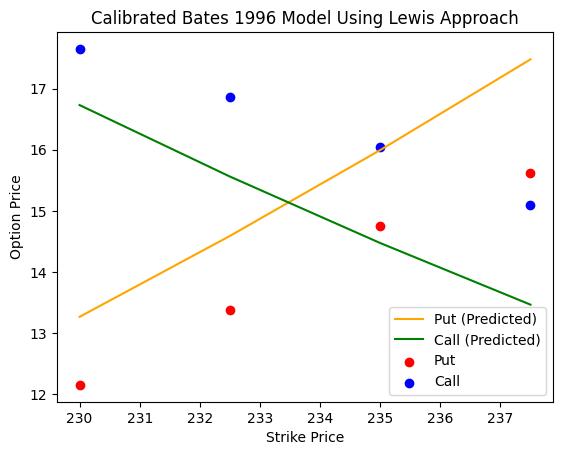

In [14]:
print("Using the Bates 1996 model with calibrated parameters to price options")

options['Call (Predicted)'] = df.apply(lambda x: B96_call_Lewis(
            S0,
            x["Strike"],
            x["T"],
            x["r"],
            calibrated_bates_Lewis["kappa_v"],
            calibrated_bates_Lewis["theta_v"],
            calibrated_bates_Lewis["sigma_v"],
            calibrated_bates_Lewis["rho"],
            calibrated_bates_Lewis["v0"],
            calibrated_bates_Lewis["lamb"],
            calibrated_bates_Lewis["mu"],
            calibrated_bates_Lewis["delta"],
        ), axis=1)
options['Put (Predicted)'] = df.apply(lambda x: B96_put_Lewis(
            S0,
            x["Strike"],
            x["T"],
            x["r"],
            calibrated_bates_Lewis["kappa_v"],
            calibrated_bates_Lewis["theta_v"],
            calibrated_bates_Lewis["sigma_v"],
            calibrated_bates_Lewis["rho"],
            calibrated_bates_Lewis["v0"],
            calibrated_bates_Lewis["lamb"],
            calibrated_bates_Lewis["mu"],
            calibrated_bates_Lewis["delta"],
        ), axis=1)

plt.scatter(options['Strike'], options['Put'], color='red', label='Put')
plt.plot(options['Strike'], options['Put (Predicted)'], color='orange', label='Put (Predicted)')
plt.scatter(options['Strike'], options['Call'], color='blue', label='Call')
plt.plot(options['Strike'], options['Call (Predicted)'], color='green', label='Call (Predicted)')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Calibrated Bates 1996 Model Using Lewis Approach')
plt.legend()
plt.show()

### The Carr-Madan approach to calibrate the Bates (1996) model

In [15]:
def B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    '''Call option price in Bates (1996) under FFT'''

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

# using put-call parity to price put options
def B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    call_value = B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
    return put_from_call(call_value, S0, K, r, T)

In [16]:
i = 0
min_MSE = 5000.0
local_opt = False

lamb, mu, delta = B96_calibration_short(B96_call_FFT, B96_put_FFT)

print("1st calibration of Bates 1996 model parameters under Carr-Madan: ")
print(f"lamb: {round(lamb,7)}")
print(f"mu: {round(mu,7)}")
print(f"delta: {round(delta,7)}")

p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

i = 0
min_MSE = 5000.0
calibrated_bates_FFT = dict(zip(["kappa_v", "theta_v", "sigma_v", "rho", "v0", "lambda", "mu", "delta"], 
                        B96_calibration_full(B96_call_FFT, B96_put_FFT)))

print("Fully calibrated Bates 1996 model parameters under Carr-Madan: ")
for k in calibrated_bates_FFT:
    print(f"{k}:\t{round(calibrated_bates_FFT[k],7)}")

1st calibration of Bates 1996 model parameters under Carr-Madan: 
lamb: 0.9060011
mu: -0.0
delta: 0.4137353
Fully calibrated Bates 1996 model parameters under Carr-Madan: 
kappa_v:	12.3462662
theta_v:	0.0118535
sigma_v:	2.8e-06
rho:	-0.0206757
v0:	0.1743942
lambda:	0.9050686
mu:	-0.0
delta:	0.4073505


Using the Bates 1996 model with calibrated parameters to price options


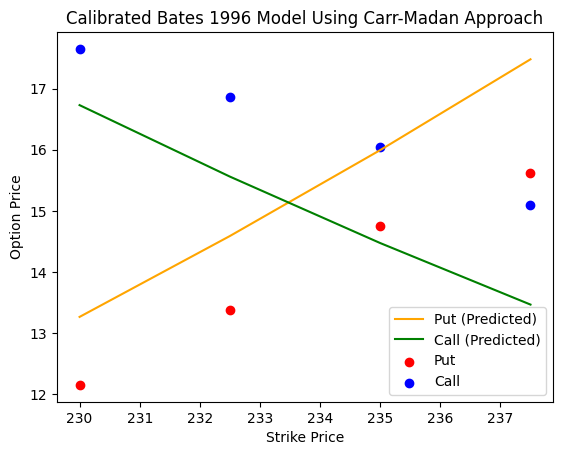

In [17]:
print("Using the Bates 1996 model with calibrated parameters to price options")

options['Call (Predicted)'] = df.apply(lambda x: B96_call_FFT(
            S0,
            x["Strike"],
            x["T"],
            x["r"],
            calibrated_bates_FFT["kappa_v"],
            calibrated_bates_FFT["theta_v"],
            calibrated_bates_FFT["sigma_v"],
            calibrated_bates_FFT["rho"],
            calibrated_bates_FFT["v0"],
            calibrated_bates_FFT["lambda"],
            calibrated_bates_FFT["mu"],
            calibrated_bates_FFT["delta"],
        ), axis=1)
options['Put (Predicted)'] = df.apply(lambda x: B96_put_FFT(
            S0,
            x["Strike"],
            x["T"],
            x["r"],
            calibrated_bates_FFT["kappa_v"],
            calibrated_bates_FFT["theta_v"],
            calibrated_bates_FFT["sigma_v"],
            calibrated_bates_FFT["rho"],
            calibrated_bates_FFT["v0"],
            calibrated_bates_FFT["lambda"],
            calibrated_bates_FFT["mu"],
            calibrated_bates_FFT["delta"],
        ), axis=1)

plt.scatter(options['Strike'], options['Put'], color='red', label='Put')
plt.plot(options['Strike'], options['Put (Predicted)'], color='orange', label='Put (Predicted)')
plt.scatter(options['Strike'], options['Call'], color='blue', label='Call')
plt.plot(options['Strike'], options['Call (Predicted)'], color='green', label='Call (Predicted)')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Calibrated Bates 1996 Model Using Carr-Madan Approach')
plt.legend()
plt.show()

Calibrating under the Carr-Madan approach gives vastly different parameters than the Lewis approach. However, the predictions are mostly consistent.

## Pricing European put option with calibrated Bates model

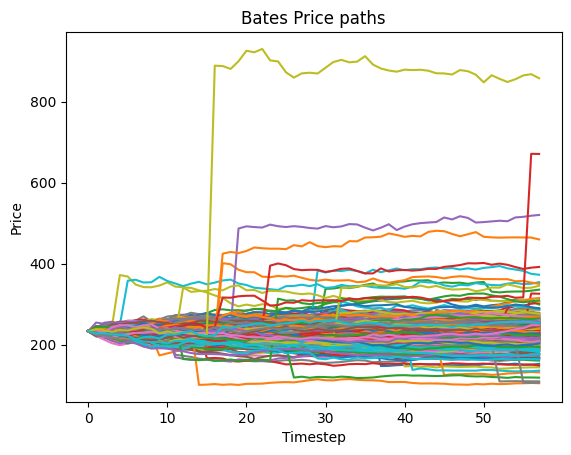

In [18]:
T = 70.0/365
K = 0.95 * S0

# underlying stock prices
def Bates_paths(S0, r, v, row, cho_matrix, lamb, mu, delta):
    S = np.zeros((M + 1, Ite), dtype=float)
    S[0] = S0
    
    rj = lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    # Random numbers
    z1 = np.random.standard_normal((M + 1, Ite))
    z2 = np.random.standard_normal((M + 1, Ite))
    y = np.random.poisson(lamb * dt, (M + 1, Ite))
    
    sdt = np.sqrt(dt)
    for t in range(1, M + 1, 1):
        ran = np.dot(cho_matrix, rand[:, t])
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[row] * sdt) * (
            np.exp((r - rj) * dt) + (np.exp(mu + delta * z2[t]) - 1) * y[t]
        )
        
        # To ensure that the price never goes below zero!
        S[t] = np.maximum(S[t], 0.00001)

    return S

M0 = 300  # Number of time steps in a year
M = int(M0 * T)  # Total time steps
Ite = 10000  # Number of simulations
dt = T / M  # Length of time step

# Using the parameters obtained under the Lewis approach
v0 = calibrated_bates_Lewis["v0"]
kappa_v = calibrated_bates_Lewis["kappa_v"]
sigma_v = calibrated_bates_Lewis["sigma_v"]
theta_v = calibrated_bates_Lewis["theta_v"]
rho = calibrated_bates_Lewis["rho"]
lamb = calibrated_bates_Lewis["lamb"]
mu = calibrated_bates_Lewis["mu"]
delta = calibrated_bates_Lewis["delta"]

# Generating random numbers from standard normal
rand = np.random.standard_normal((2, M + 1, Ite))

# Covariance Matrix
covariance_matrix = np.zeros((2, 2), dtype=float)
covariance_matrix[0] = [1.0, rho]
covariance_matrix[1] = [rho, 1.0]
cho_matrix = np.linalg.cholesky(covariance_matrix)

# Volatility process paths
V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, Ite, rand, 1, cho_matrix)

# Underlying price process paths
S = Bates_paths(S0, r, V, 0, cho_matrix, lamb, mu, delta)

plt.plot(range(len(S)), S[:, :300])
plt.title("Bates Price paths")
plt.ylabel("Price")
plt.xlabel("Timestep")
plt.show()

In [19]:
def bates_put_mc(S, K, r, T):
    payoff = np.maximum(0, K-S[-1, :])
    average = np.mean(payoff)

    return np.exp(-r*T) * average

put_value = bates_put_mc(S, K, r, T)
print("Price of European option under Bates: \t", round(put_value, 2))

fees = 0.04 * put_value
print("4% fee charged to client: \t\t", round(fees, 2))

print("Total price to be paid by client: \t", round(put_value+fees, 2))

Price of European option under Bates: 	 9.96
4% fee charged to client: 		 0.4
Total price to be paid by client: 	 10.36


## Step 3

## Calibrating CIR model

Note: Euribor uses the 30/360 convention for month/year.
We use the cubic spline method to interpolate 24 evenly spaced maturities in 1 year.


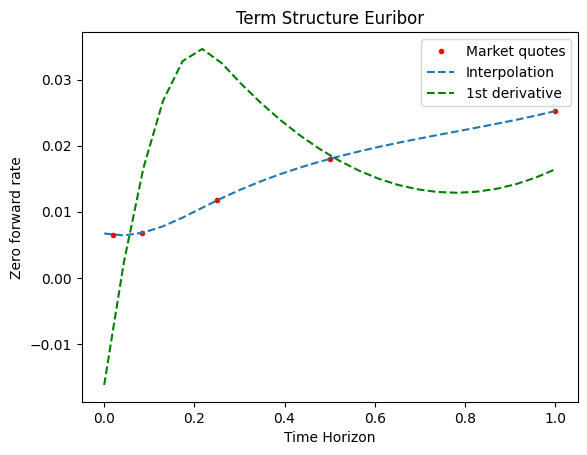

In [20]:
# Adapted from Stochastic Modeling Module 3 Lesson 2

print("Note: Euribor uses the 30/360 convention for month/year.")
mat_list = np.array((7, 30, 90, 180, 360)) / 360
rate_list = (np.array((0.648, 0.679, 1.173, 1.809, 2.556)) / 100)

r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)

print("We use the cubic spline method to interpolate 24 evenly spaced maturities in 1 year.")
# Cubic spline
bspline = splrep(mat_list, zero_rates, k=3)
# Create 24 equally spaced maturities between 0 and 1
mat_list_n = np.linspace(0.0, 1.0, 24)
inter_rates = splev(mat_list_n, bspline, der=0) # Interpolated rates
first_der = splev(mat_list_n, bspline, der=1) # First derivative of spline

# Forward rate given interpolated ones and first derivative
f = (inter_rates + first_der * mat_list_n)

plt.plot(mat_list, zero_rates, "r.", label="Market quotes")
plt.plot(mat_list_n, inter_rates, "--", label="Interpolation")
plt.plot(mat_list_n, first_der, "g--", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

In [21]:
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2

def CIR_error_function(alpha):
    '''Error function to calibrate CIR (1985) model'''

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
        disp=False
    )

    return opt

In [22]:
params = CIR_calibration()

calibrated_CIR = dict(zip(["kappa_r", "theta_r", "sigma_r"], 
                        CIR_calibration()))

print("Calibrated CIR model parameters: ")
for k in calibrated_CIR:
    print(f"{k}:\t{round(calibrated_CIR[k],7)}")

Calibrated CIR model parameters: 
kappa_r:	0.989083
theta_r:	0.1086319
sigma_r:	0.0010007


Using the calibrated CIR model to predict Euribor interest rates


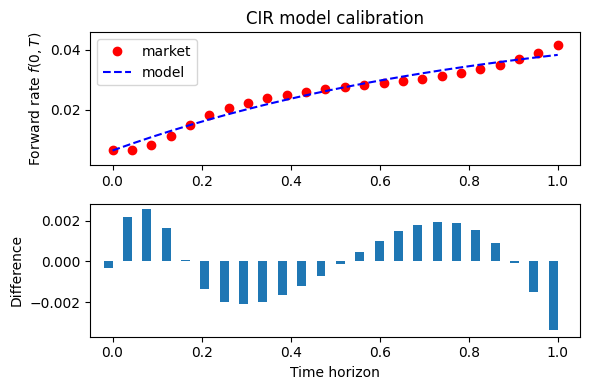

In [23]:
def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves"""
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(6, 4))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()

print("Using the calibrated CIR model to predict Euribor interest rates")
plot_calibrated_frc(params)

## Simulating 12-months rate with calibrated CIR model

In [24]:
M = 10000  # Number of paths for MC
N = 100  # Number of steps
T = 1.0  # Maturity
r0 = rate_list[-1]
k = calibrated_CIR['kappa_r']
theta = calibrated_CIR['theta_r']
sigma = calibrated_CIR['sigma_r']

def cir(r0, k, theta, sigma, T, N, M):
    dt = T / N
    rates = np.zeros((N, M))
    rates[0, :] = r0
    for j in range(M):
        for i in range(1, N):
            dr = (
                k * (theta - rates[i - 1, j]) * dt
                + sigma
                * np.sqrt(dt)
                * np.sqrt(np.maximum(rates[i - 1, j], 0))
                * np.random.normal()
            )
            rates[i, j] = rates[i - 1, j] + dr
    return rates

rates_cir = cir(r0, k, theta, sigma, T, N, M)

Using the CIR parameters obtained from calibration previously.


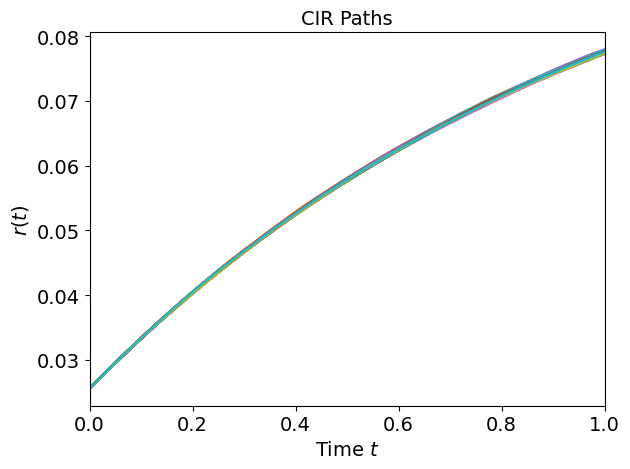

In [25]:
print("Using the CIR parameters obtained from calibration previously.")

t = np.linspace(0, T, N)
for j in range(100): # default M, but too many to plot all
    plt.plot(t, rates_cir[:, j])

plt.xlabel("Time $t$", fontsize=14)
plt.ylabel("$r(t)$", fontsize=14)
plt.title("CIR Paths", fontsize=14)
axes = plt.gca()
axes.set_xlim([0, T])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

Let us consider the most extreme 10% to be outlier. To see where the 12-month Euribor rate could be, we can look at the value of the 10th and 90th percentile values.

In [26]:
twelve_months_rates = rates_cir[-1]

print("10th percentile:\t", round(np.percentile(twelve_months_rates, 10, axis=0),5))
print("90th percentile:\t", round(np.percentile(twelve_months_rates, 90, axis=0),5))

print("Expected value:\t\t", round(np.average(twelve_months_rates),5))

10th percentile:	 0.07737
90th percentile:	 0.07779
Expected value:		 0.07758


Graphically, the CIR model say that the 12-month Euribor rate is projected to rise. With the Euro being a major global currency, the Euribor rate can be taken as the risk-free rate (r). Therefore, it affects the pricing in the various models such as Heston 1993 and Bates 1996 used in the previous sections. 